## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [37]:
import os
import keras
from keras.layers import BatchNormalization

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [38]:
train, test = keras.datasets.cifar10.load_data()

In [39]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [40]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [41]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [42]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_18 (Batc (None, 128)               512 

50000/50000 [==============================] - 4s 70us/step - loss: 0.5746 - accuracy: 0.8303 - val_loss: 1.6131 - val_accuracy: 0.4927
Epoch 47/50
50000/50000 [==============================] - 4s 71us/step - loss: 0.5581 - accuracy: 0.8366 - val_loss: 1.6285 - val_accuracy: 0.4874
Epoch 48/50
50000/50000 [==============================] - 3s 70us/step - loss: 0.5396 - accuracy: 0.8436 - val_loss: 1.6381 - val_accuracy: 0.4912
Epoch 49/50
50000/50000 [==============================] - 3s 69us/step - loss: 0.5226 - accuracy: 0.8520 - val_loss: 1.6734 - val_accuracy: 0.4831
Epoch 50/50
10000/10000 [==============================] - 1s 67us/step
loss_loadback 1.4564141027450561
acc_loadback 0.4959000051021576


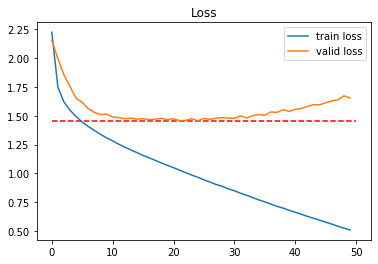

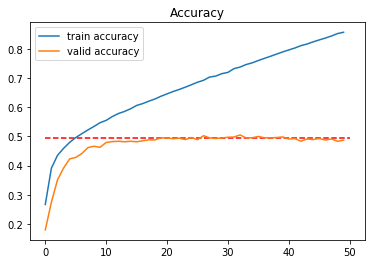

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_19 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_20 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_21 (Batc (None, 128)               512 

50000/50000 [==============================] - 4s 71us/step - loss: 0.5632 - accuracy: 0.8341 - val_loss: 1.6350 - val_accuracy: 0.4947
Epoch 47/50
50000/50000 [==============================] - 4s 73us/step - loss: 0.5446 - accuracy: 0.8402 - val_loss: 1.6744 - val_accuracy: 0.4876
Epoch 48/50
50000/50000 [==============================] - 4s 79us/step - loss: 0.5288 - accuracy: 0.8485 - val_loss: 1.6677 - val_accuracy: 0.4907
Epoch 49/50
50000/50000 [==============================] - 4s 71us/step - loss: 0.5112 - accuracy: 0.8541 - val_loss: 1.6633 - val_accuracy: 0.4876
Epoch 50/50
10000/10000 [==============================] - 1s 73us/step
loss_loadback 1.705108875656128
acc_loadback 0.4887999892234802


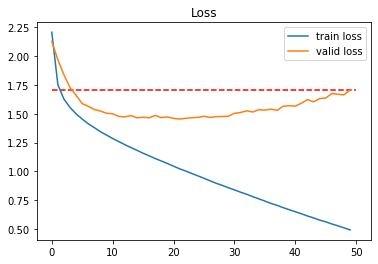

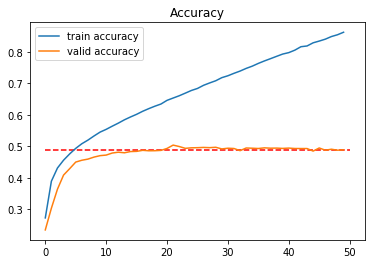

In [43]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
from keras.callbacks import ModelCheckpoint


results = {}

for save_best_only in [True, False]:
    model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                             monitor="val_loss", 
                             save_best_only=save_best_only)
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[model_ckpt]
             )
    # Collect results    
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    name_tag = 'save_best_only: %s' % str(save_best_only)
    results[name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}
    
    # Load back
    model = keras.models.load_model("./tmp.h5")
    loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
    print("loss_loadback", loss_loadback)
    print("acc_loadback", acc_loadback)

    import matplotlib.pyplot as plt
    %matplotlib inline

    plt.plot(range(len(train_loss)), train_loss, label="train loss")
    plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
    plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
    plt.legend()
    plt.title("Loss")
    plt.show()

    plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
    plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
    plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
    plt.legend()
    plt.title("Accuracy")
    plt.show()
